In [1]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras import layers
from keras.layers import Embedding, Flatten, Dense, Conv1D, LSTM, GRU, AveragePooling1D, Dropout, Bidirectional
from keras.optimizers import Adam
#import tensorflow as tf
from sklearn.preprocessing import scale
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import precision_recall_fscore_support
from corpora_utils import CorporaHelper,CorporaDomains, CorporaProperties
import numpy as np
import os
import pickle

Using TensorFlow backend.


In [2]:
"""
#Activate GPU
#WARNING GPU TAKES 5 TIMES LONGER THAN CPU! With Consul Project 1
#Check for GPU
tf.test.is_gpu_available(
    cuda_only=False, min_cuda_compute_capability=None
)
# GPU CONFIG
config = tf.compat.v1.ConfigProto(
    gpu_options = tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=0.8)
    # device_count = {'GPU': 1}
)
config.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config=config)
tf.compat.v1.keras.backend.set_session(session)
sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(log_device_placement=True))
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
"""

#Deactivate GPU
try:
    # Disable all GPUS
    tf.config.set_visible_devices([], 'GPU')
    visible_devices = tf.config.get_visible_devices()
    for device in visible_devices:
        assert device.device_type != 'GPU'
except:
    # Invalid device or cannot modify virtual devices once initialized.
    pass
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"


In [3]:
MULTIGENRE = 'muligenre'
TWITTER = 'twitter'
MG_AND_TWITTER = 'mg_and_twitter'

# set wich corpora to use Multigenre or twitter
use_mg_train_corpora = MG_AND_TWITTER

In [4]:
# load data
train_labels = []
train_texts = []
test_labels = []
test_texts = []

In [5]:
def load_corpora(filepath, sep=';'):
    print('Load: ', filepath)
    corpora_helper = CorporaHelper(filepath, separator=sep)
    count_joy = 0
    count_sadness = 0
    count_anger = 0
    count_fear = 0
    labels = []
    texts = []
    # preprocessing corpora
    corpora_helper.translate_urls()
    corpora_helper.translate_emoticons()
    corpora_helper.translate_emojis()
    corpora_helper.translate_email()
    #corpora_helper.translate_mention()
    corpora_helper.translate_html_tags()
    #corpora_helper.translate_camel_case()
    corpora_helper.translate_underscore()

    corpora_helper.translate_string('-LRB-','(')
    corpora_helper.translate_string('-RRB-',')')
    corpora_helper.translate_string('`',"'") # ` to '
    corpora_helper.translate_string("''",'"') # double '' to "
    corpora_helper.translate_contractions()
    corpora_helper.translate_string("'","") # remove '
    corpora_helper.translate_string("\\n"," ") # replace new lines with space

    #corpora_helper.spell_correction()
    corpora_helper.add_space_at_special_chars()
    corpora_helper.add_space_at_special_chars(regexlist = r"([#])")
    #corpora_helper.translate_to_lower()

    # 0 anger
    # 1 fear
    # 2 joy
    # 3 sadness
    for index, corpus in corpora_helper.get_data().iterrows():
        if corpus[CorporaProperties.EMOTION.value] == 'anger':
            texts.append(corpus[CorporaProperties.CLEANED_CORPUS.value])
            labels.append(0)
            count_anger += 1
        elif corpus[CorporaProperties.EMOTION.value] == 'fear':
            texts.append(corpus[CorporaProperties.CLEANED_CORPUS.value])
            labels.append(1)
            count_fear += 1
        elif corpus[CorporaProperties.EMOTION.value] == 'joy':
            texts.append(corpus[CorporaProperties.CLEANED_CORPUS.value])
            labels.append(2)
            count_joy += 1
        elif corpus[CorporaProperties.EMOTION.value] == 'sadness':
            texts.append(corpus[CorporaProperties.CLEANED_CORPUS.value])
            labels.append(3)
            count_sadness += 1
    print('number of anger labels: ',count_anger)
    print('number of fear labels: ', count_fear)
    print('number of joy labels: ', count_joy)
    print('number of sadness labels: ', count_sadness)
    print('----------------------------------------------------------------------')
    return texts, labels
    #max_data = count_anger + count_fear + count_joy + count_sadness


In [6]:
train_file = ""
test_file = ""
sep = ';'
word_embeddings_path = ''
if use_mg_train_corpora == MULTIGENRE:
    train_file = "corpora/multigenre_450_train.csv"
    test_file = "corpora/multigenre_450_test.csv"
    word_embeddings_path = 'custom_embedding/multi_embedding.pkl'
    sep = ';'
    print("Use MULTIGENRE train corpora")
elif use_mg_train_corpora == TWITTER:
    train_file = "corpora/twitter_2000_train.csv"
    test_file = "corpora/twitter_2000_test.csv"
    word_embeddings_path = 'custom_embedding/multi_embedding.pkl'
    sep = '\t'
    print("Use TWITTER train corpora")
else:
    train_file = "corpora/twitter_2000_mg_450_train.csv"
    test_file = "corpora/twitter_2000_mg_450_test.csv"
    word_embeddings_path = 'custom_embedding/multi_embedding.pkl'
    sep = '\t'
    print("Use TWITTER and MULTIGENRE train corpora")
    
train_texts, train_labels = load_corpora(train_file, sep=sep)
test_texts, test_labels = load_corpora(test_file, sep=sep)

Use TWITTER and MULTIGENRE train corpora
Load:  corpora/twitter_2000_mg_450_train.csv
number of anger labels:  2205
number of fear labels:  2205
number of joy labels:  2205
number of sadness labels:  2205
----------------------------------------------------------------------
Load:  corpora/twitter_2000_mg_450_test.csv
number of anger labels:  245
number of fear labels:  245
number of joy labels:  245
number of sadness labels:  245
----------------------------------------------------------------------


In [7]:
# Load prepared custom ensemble embedding
with open(word_embeddings_path, 'rb') as word_embeddings_file:
    embedding_info = pickle.load(word_embeddings_file)

In [8]:
# Embedding helper functions
def is_active_vector_method(string):
    return int(string)
    
def get_unigram_embedding(word, word_embedding_dict, bin_string):
    
    if word in word_embedding_dict:
        word_feature_embedding_dict = word_embedding_dict[word]
        final_embedding = np.array([])
    else:
        return None
    
    for i in range(16):
        if is_active_vector_method(bin_string[i]):
            final_embedding = np.append(final_embedding, word_feature_embedding_dict[i])
    
    return final_embedding

In [9]:
pre_padding = 0
embeddings_index = embedding_info[0]
MAX_SEQUENCE_LENGTH = embedding_info[1]
maxlen = MAX_SEQUENCE_LENGTH
print("maxlen: ",maxlen)
#MAX_NB_WORDS = 10000

maxlen:  100


# Selection Unigram Features

In [22]:
# selecting relevant embeddings for multigenre
if use_mg_train_corpora == MULTIGENRE:
    # Multigenre
    unigram_feature_string = "1001111111111101"
elif use_mg_train_corpora == TWITTER:
    # Twitter
    unigram_feature_string = "0110001111111101"
    unigram_feature_string = "1111111111111111"
else:
    # Twitter and Multigenre
    unigram_feature_string = "1110010000000000"
# 1 Google news pretrained vectors : GoogleNews-vectors-negative300.bin.gz  
# 2 Twitter pretrained vectors: word2vec_twitter_model.bin
# 3 glove.twitter.27B.200d.txt
# 4 glove.6B.300d.txt
# 5 glove.42B.300d.txt
# 6 glove.840B.300d.txt
# 7 NRC Emotion Intensity Lexicon
# 8 senti word net
#9  NRC Sentiment lexicon: NRC-Emotion-Lexicon-Wordlevel-v0.92.txt
#10 lexicons/Emoticon-unigrams.txt
#11 lexicons/Emoticon-AFFLEX-NEGLEX-unigrams.txt
#12 NRC Hashtag Lexica: NRC-Emotion-Lexicon-Wordlevel-v0.92.txt
#13 HS-unigrams.txtNRC-Hashtag-Emotion-Lexicon-v0.2.txt
#14 HS-AFFLEX-NEGLEX-unigrams.txt
#15 Emoji Polarities
#16 Depeche mood

In [23]:
"""
Deep learning with multigenre and twitter corpus and 4 emotions
"""
# K-Fold variables
num_folds = 3 # 10
fold_runs = 1 # 3
fold_no = 1
# train
epochs = 5
max_words = 10000
# max. different words:
# Multigerne: 5140  => 10000 or 3000 or 1000 ?
# Twitter: 17580 => 20000 or 10000 ?
# MG and Twitter: 20073 => evtl. 20000?
#optimizer = keras.optimizers.Adam(learning_rate=0.01)
optimizer = Adam(learning_rate=0.001) # default 0.001
skfold = StratifiedKFold(n_splits = num_folds, random_state = 7, shuffle = True)
acc_per_fold = []
loss_per_fold = []
precision_per_fold = []
recall_per_fold = []
f1_per_fold = []
avg_acc_per_run = []
avg_loss_per_run = []
avg_precision_per_run = []
avg_recall_per_run = []
avg_f1_per_run = []
create_final_model = True
# run only final model without kfold
run_final_train_only = False

In [12]:
EMBEDDING_DIM = len(get_unigram_embedding("glad", embedding_info[0], unigram_feature_string))
print("Embedding dimension:",EMBEDDING_DIM)


tokenizer = Tokenizer(num_words=max_words, filters = '')

Embedding dimension: 1200


In [13]:
# Create train an test data set
def create_data(texts, labels, maxlen):
    ## Create one hot encoding
    #max_words = 10000
    #maxlen = 100 # max. number of words in sequences
    #tokenizer = Tokenizer(num_words=max_words, filters = '')
    #tokenizer.fit_on_texts(texts)
    sequences = tokenizer.texts_to_sequences(texts)

    #word_i = tokenizer.word_index

    data = pad_sequences(sequences, maxlen=maxlen)

    labels_arr = np.asarray(labels)
    print('Shape of data:', data.shape)
    print('Shape of labels:', labels_arr.shape)
    print('-------------------------------------------')

    # mix the data
    indices = np.arange(data.shape[0])
    np.random.shuffle(indices)
    data = data[indices]
    labels_arr = labels_arr[indices]

    # split in train and validate
    x_data = data
    y_data = labels_arr
    return x_data, y_data

In [14]:
# fit tokenizer
all_texts = train_texts.copy()
all_texts.append(test_texts.copy())
tokenizer.fit_on_texts(all_texts)

In [15]:
# Train an word index for embedding enrichment
x_train, y_train = create_data(train_texts, train_labels, maxlen)
x_test, y_test = create_data(test_texts, test_labels, maxlen)
word_index = tokenizer.word_index
x_train_copy = x_train.copy()
y_train_copy = y_train.copy()
print ('%s unique Tokens found.' % len(word_index))

Shape of data: (8820, 100)
Shape of labels: (8820,)
-------------------------------------------
Shape of data: (980, 100)
Shape of labels: (980,)
-------------------------------------------
19020 unique Tokens found.


In [16]:
# Build Matrix
word_embedding_matrix = list()
word_embedding_matrix = np.zeros((max_words, EMBEDDING_DIM))
#word_embedding_matrix.append(np.zeros(EMBEDDING_DIM))

In [17]:
for word, i in word_index.items(): # sorted(word_indices, key=word_indices.get):
    embedding_features = get_unigram_embedding(word, embedding_info[0], unigram_feature_string)
    if i < max_words:
        if embedding_features is not None:
            # Words not found in embedding index will be all-zeros.
            word_embedding_matrix[i] = embedding_features

word_embedding_matrix = np.asarray(word_embedding_matrix, dtype='f')
word_embedding_matrix = scale(word_embedding_matrix)

C:\Users\COMMANDER\.conda\envs\gputest\lib\site-packages\sklearn\preprocessing\_data.py:174: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "
C:\Users\COMMANDER\.conda\envs\gputest\lib\site-packages\sklearn\preprocessing\_data.py:191: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "


In [18]:
#print('word_indices_len',word_indices_len)
print('EMBEDDING_DIM',EMBEDDING_DIM)
print('input_length', MAX_SEQUENCE_LENGTH + pre_padding)
embedding = Embedding(max_words, EMBEDDING_DIM, input_length=maxlen, trainable=False)
#embedding = Embedding(word_indices_len + 1, EMBEDDING_DIM,input_length=MAX_SEQUENCE_LENGTH + pre_padding, trainable=False)

EMBEDDING_DIM 1200
input_length 100


In [19]:
"""
def create_model():

    # Create model

    model = Sequential()
    model.add(embedding)
    model.add(Conv1D(32,5, activation='relu'))
    #model.add(layers.GRU(32,dropout=0.4, recurrent_dropout=0.4)) #acc = 25 
    #model.add(layers.LSTM(32,dropout=0.6, recurrent_dropout=0.6)) #acc = 83.7
    #model.add(layers.Bidirectional(layers.LSTM(32,dropout=0.6, recurrent_dropout=0.6))) #acc = 83.2
    #model.add(layers.Bidirectional(layers.LSTM(32,dropout=0.5, recurrent_dropout=0.5))) #acc = 83.4
    #model.add(layers.Bidirectional(layers.LSTM(32,dropout=0.4, recurrent_dropout=0.4))) #acc = 84.5
    #model.add(layers.Bidirectional(layers.LSTM(32,dropout=0.3, recurrent_dropout=0.3))) #acc = 85.2
    #model.add(Dense(8, activation='relu'))
    #model.add(Dense(32, activation='relu'))
    model.add(Dense(4, activation='softmax'))

    return model
"""

"\ndef create_model():\n\n    # Create model\n\n    model = Sequential()\n    model.add(embedding)\n    model.add(Conv1D(32,5, activation='relu'))\n    #model.add(layers.GRU(32,dropout=0.4, recurrent_dropout=0.4)) #acc = 25 \n    #model.add(layers.LSTM(32,dropout=0.6, recurrent_dropout=0.6)) #acc = 83.7\n    #model.add(layers.Bidirectional(layers.LSTM(32,dropout=0.6, recurrent_dropout=0.6))) #acc = 83.2\n    #model.add(layers.Bidirectional(layers.LSTM(32,dropout=0.5, recurrent_dropout=0.5))) #acc = 83.4\n    #model.add(layers.Bidirectional(layers.LSTM(32,dropout=0.4, recurrent_dropout=0.4))) #acc = 84.5\n    #model.add(layers.Bidirectional(layers.LSTM(32,dropout=0.3, recurrent_dropout=0.3))) #acc = 85.2\n    #model.add(Dense(8, activation='relu'))\n    #model.add(Dense(32, activation='relu'))\n    model.add(Dense(4, activation='softmax'))\n\n    return model\n"

## CNN-Model

In [237]:
"""
def create_model():
    # Create model
    model = Sequential()
    model.add(embedding)
    model.add(Conv1D(128, 3, activation='relu'))
    model.add(Dense(200, activation='relu'))
    model.add(Dropout(0.5))
    model.add(layers.GlobalMaxPooling1D())
    model.add(Dense(4, activation='softmax'))
    model.compile(loss='mean_squared_error', optimizer="Adam", learningrate = 0.001)

    return model

## LSTM-Model (RNN)

In [542]:
"""
def create_model():
    # Create model
    model = Sequential()
    model.add(embedding)
        
    model.add(LSTM(32, dropout=0.4, recurrent_dropout=0.4, return_sequences=True))
    
    model.add(Dense(16, activation='relu'))

    model.add(layers.GlobalMaxPooling1D())
    model.add(Dense(4, activation='softmax'))
    model.compile(loss='mean_squared_error', optimizer="Adam", learningrate = 0.001)

    return model

## BiLSTM-Model (RNN)

In [20]:
def create_model():
    # Create model
    model = Sequential()
    model.add(embedding)
        
    model.add(Bidirectional(LSTM(32, dropout=0.5, recurrent_dropout=0.5, return_sequences=True)))
    
    model.add(Dense(16, activation='relu'))
    
    model.add(layers.GlobalMaxPooling1D())
    model.add(Dense(4, activation='softmax'))
    model.compile(loss='mean_squared_error', optimizer="Adam", learningrate = 0.001)

    return model

## GRU (RNN)

In [349]:
"""
def create_model():
    # Create model
    model = Sequential()
    model.add(embedding)
    
    model.add(Conv1D(64, 3, activation='relu'))
    model.add(GRU(64, dropout=0.25, recurrent_dropout=0.25, return_sequences=True))
    model.add(LSTM(32, dropout=0.2, recurrent_dropout=0.2, return_sequences=True))

    
    model.add(Dense(32, activation='relu'))
    model.add(layers.GlobalMaxPooling1D())
    model.add(Dense(4, activation='softmax'))
    model.compile(loss='mean_squared_error', optimizer="Adam", learningrate = 0.001)

    return model

# Run the Model

------------------------------------------------------------------------
Training for fold 1 ind run 1 ...
Train on 5880 samples, validate on 2940 samples
Epoch 1/5
5880/5880 [==============================] - 18s 3ms/step - loss: 1.1588 - acc: 0.5009 - val_loss: 0.7093 - val_acc: 0.7289
Epoch 2/5
5880/5880 [==============================] - 17s 3ms/step - loss: 0.6288 - acc: 0.7665 - val_loss: 0.4913 - val_acc: 0.8126
Epoch 3/5
5880/5880 [==============================] - 17s 3ms/step - loss: 0.4695 - acc: 0.8299 - val_loss: 0.4520 - val_acc: 0.8241
Epoch 4/5
5880/5880 [==============================] - 17s 3ms/step - loss: 0.3870 - acc: 0.8583 - val_loss: 0.4098 - val_acc: 0.8412
Epoch 5/5
2940/2940 [==============================] - 4s 1ms/step
Score for fold 1: loss of 0.39943946352621323; accuracy of 84.42176580429077%
2940/2940 [==============================] - 4s 1ms/step
------------------------------------------------------------------------
Training for fold 2 ind run 1 ...


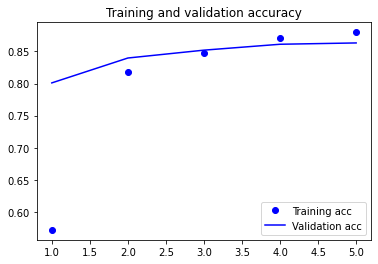

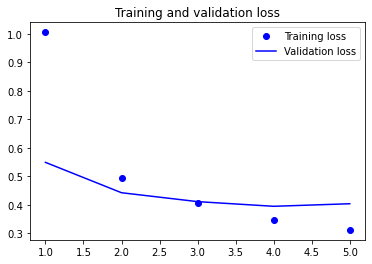

In [24]:
# run x Times the folds
if not run_final_train_only:
    for run_num in range(1,fold_runs+1):
        # k-fold
        for train_ind, val_ind in skfold.split(x_train,y_train):

            # Create model
            model = create_model()

            # Load GloVe embedding
            model.layers[0].set_weights([word_embedding_matrix])
            model.layers[0].trainable = False

            # Train and Evaluate
            model.compile(optimizer=optimizer,
                        loss='sparse_categorical_crossentropy',
                        metrics=['acc'])
            print('------------------------------------------------------------------------')
            print(f'Training for fold {fold_no} ind run {run_num} ...')

            history = model.fit(x_train[train_ind], y_train[train_ind],
                                epochs=epochs,
                                batch_size=64,
                                verbose=1,
                                validation_data=(x_train[val_ind], y_train[val_ind]))

            # metrics
            scores = model.evaluate(x_train[val_ind], y_train[val_ind], batch_size=32)
            #print(f'Score for fold {fold_no}: {model.metrics_name[0]} of {scores[0]}; {model.metrics_name[1]} of {scores[1]*100}%')
            print(f'Score for fold {fold_no}: loss of {scores[0]}; accuracy of {scores[1]*100}%')
            acc_per_fold.append(scores[1]*100)
            loss_per_fold.append(scores[0])

            # Evaluation metrics precison recall f1
            y_pred = model.predict(x_train[val_ind], batch_size=64, verbose=1)
            y_pred_bool = np.argmax(y_pred, axis=1)
            precision, recall, f1, support = precision_recall_fscore_support(y_train[val_ind], y_pred_bool)
            mean_precision = np.mean(precision)
            mean_recall = np.mean(recall)
            mean_f1 = np.mean(f1)
            precision_per_fold.append(mean_precision)
            recall_per_fold.append(mean_recall)
            f1_per_fold.append(mean_f1)

            fold_no += 1

        # == Provide average scores ==
        print('------------------------------------------------------------------------')
        print('Score per fold')
        for i in range(0, len(acc_per_fold)):
            print('------------------------------------------------------------------------')
            print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
        print('------------------------------------------------------------------------')
        print('Average scores for all folds:')
        avg_acc_per_run.append(np.mean(acc_per_fold))
        avg_loss_per_run.append(np.mean(loss_per_fold))
        avg_precision_per_run.append(np.mean(precision_per_fold))
        avg_recall_per_run.append(np.mean(recall_per_fold))
        avg_f1_per_run.append(np.mean(f1_per_fold))

        print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
        print(f'> Loss: {np.mean(loss_per_fold)}')
        print(f'> Precision: {np.mean(precision_per_fold)}')
        print(f'> Recall: {np.mean(recall_per_fold)}')
        print(f'> F1: {np.mean(f1_per_fold)}')
        print('------------------------------------------------------------------------')

        # reset fold vars
        acc_per_fold = []
        loss_per_fold = []
        precision_per_fold = []
        recall_per_fold = []
        f1_per_fold = []
        fold_no = 1

    # == Provide average scores ==
    print('------------------------------------------------------------------------')
    print('Score for k-fold runs')
    for i in range(0, len(avg_acc_per_run)):
        print('------------------------------------------------------------------------')
        print(f'> Run {i+1} Fold averages - Loss: {avg_loss_per_run[i]} - Accuracy: {avg_acc_per_run[i]}% ')
        print(f'> Run {i+1} Fold averages - Precision: {avg_precision_per_run[i]} - Recall: {avg_recall_per_run[i]} F1: {avg_f1_per_run[i]}')
    print('------------------------------------------------------------------------')
    print(f'Overall average scores for all {fold_runs} runs:')
    print(f'> Accuracy: {np.mean(avg_acc_per_run)} (+- {np.std(avg_acc_per_run)})')
    print(f'> Loss: {np.mean(avg_loss_per_run)}')
    print(f'> Precision: {np.mean(avg_precision_per_run)}')
    print(f'> Recall: {np.mean(avg_recall_per_run)}')
    print(f'> F1: {np.mean(avg_f1_per_run)}')
    print('------------------------------------------------------------------------')

# create final model #Todo sync with fold rund
if create_final_model:
    model = create_model()
    model.summary()

    # Load GloVe embedding
    model.layers[0].set_weights([word_embedding_matrix])
    model.layers[0].trainable = False

    # Train and Evaluate
    model.compile(optimizer='adam',
                loss='sparse_categorical_crossentropy',
                metrics=['acc'])
    print('------------------------------------------------------------------------')
    print('Training for final model ...')

    history = model.fit(x_train_copy, y_train_copy,
                        epochs=epochs,
                        batch_size=64,
                        verbose=1,
                        validation_data=(x_test, y_test))
    # Save Model
    if use_mg_train_corpora == MULTIGENRE:
        model.save('models/model_emotion_detection_multigenre.h5')
        pickle.dump(tokenizer, open("models/tokenizer_multigenre.pkl", "wb"))
    elif use_mg_train_corpora == TWITTER:
        model.save('models/model_emotion_detection_twitter.h5')
        pickle.dump(tokenizer, open("models/tokenizer_twitter.pkl", "wb"))
    else:
        model.save('models/model_emotion_detection_multigenre_twitter.h5')
        pickle.dump(tokenizer, open("models/tokenizer_multigenre_twitter.pkl", "wb"))

    # Test final model
    print("Evaluate final model on test data")
    results = model.evaluate(x_test, y_test, batch_size=128)
    print("test loss, test acc:", results)
    # For Model evaluation metrics run evalModel

    # Plot performance
    import matplotlib.pyplot as plt

    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc) + 1)

    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.figure()

    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()

In [521]:
"""
Analysis of Lexicon features
Results of Final model generated with BiLSTM-NN from 3 k-Folds and 2 runs with various unigram features:

                                                                   Run1 | Run2            Run1 | Run2
Unigram feature:  Description:                                     F1-overall:    loss,  acc (on final model):   Epochs:
1110010000000000  without NRC and DepecheMood                      84.6 | 83.7    0.398, 0.865 | 0.402, 0.856     5 
1110010000000001  with DepecheMood                                 84.0 | 84.0    0.405, 0.861 | 0.398, 0.852     5
1110010010000000  with NRC                                         84.7 | 84.2    0.389, 0.860 | 0.375, 0.860     5
1110011000000000  with NRC Emotion Intensity                       84.6 | 84.7    0.404, 0.852 | 0.409, 0.854     5   
1110011010000001  with NRC Emotion Intensity, NRC and DepecheMood  84.3 | 84.3    0.404, 0.859 | 0.408, 0.862     5 
1111111111111111  all unigram features acitvated                   84.6 | 84.8    0.432, 0.852 | 0.367, 0.868     5 


Analysis of Embedding features
Results of Final model generated with BiLSTM-NN from 3 k-Folds and 2 runs with various unigram features:

                                                                   Run1 | Run2            Run1 | Run2
Unigram feature:  Description:                                     F1-overall:    loss,  acc (on final model):   Epochs:
1000000000000000  only Word2Vec Google News Embedding              84.0 | 83.3    0.446, 0.843 | 0.459, 0.837     5
0100000000000000  only Word2Vec Twitter News Embedding             84.0 | 83.6    0.460, 0.850 | 0.440, 0.847     5
0010000000000000  only GloVe Twitter Embedding                     81.9 | 82.6    0.439, 0.847 | 0.465, 0.823    10
0000010000000000  only Glove Common Crawl Embedding                84.5 | 84.8    0.430, 0.849 | 0.417, 0.848    10
1100010000000000  all Embeddings without GloVe Twitter             84.3 | 83.9    0.408, 0.853 | 0.412, 0.856     5
1110010000000000  all Embeddings                                   84.7 | 84.7    0.384, 0.867 | 0.404, 0.863     5                5
"""

'\nResults of Final model generated from 3 k-Folds and 2 runs with various unigram features:\n\nDescription:                                          F1:          Unigram feature:     test loss, test acc on final model:\nwithout NRC and DepecheMood                           84.7 | 83.9  "1110010000000000"   0.412, 0.849 | 0.388, 0.861\nwith depechemood                                      84.6 |       "1110010000000001"   0.405, 0.861 |\nwith NRC                                              86.0         "1110010010000000"\nwith NRC Emotion Intensity                            84.2 | 84.5  "1110011000000000"   0.380, 0.864. | 0.405, 0.851\nwith NRC Emotion Intensity and NRC and Depechemood    85.8   "1110011010000001" \nall unigram features acitvated                        85.0   "1111111111111111"\n'